# PRE PROCESSING DATA

In [1]:
from sklearn.datasets import fetch_kddcup99
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from time import time

## SET UP SPARK

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/04 14:01:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# create a spark context
sc = spark.sparkContext

## DESCRIBE THE DATA SET

In [4]:
data = fetch_kddcup99(return_X_y = True, percent10 = True) # default percent10=True

In [5]:
print("The number of samples is ", data[0].shape[0])
print("The dimensionality is ", data[0].shape[1])

The number of samples is  494021
The dimensionality is  41


Classes: 23
Samples total: 4898431
Dimensionality: 41
Features: discrete (int) or continuous (float)

The first containing a 2D array of shape (n_samples, n_features) with each row representing one sample and each column representing the features


The first 4 elements of the data set (letters, what are them)
Duration: The length (in seconds) of the connection.
Protocol Type: The type of protocol used, such as TCP, UDP, or ICMP.
Service: The network service on the destination, such as HTTP, FTP, or SMTP.
Flag: The status flag of the connection, such as SF (successful connection), REJ (connection rejected), etc.

In [6]:
# collect samples and features (target)
x = data[0]
y = data[1] 

# to delete later on
np.random.seed(12345)
shuffled_indices = np.random.permutation(len(x))
x=x[shuffled_indices]
y=y[shuffled_indices]

subLen = 1000
x = x[:subLen,]
y = y[:subLen]

In [7]:
# cycle over num_slices to be run on cloud veneto on a .py

In [8]:
nSlice = None # IMPORTANT PARAMETER FOR NUMBER OF PARTITIONS
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))], numSlices = nSlice)

In [9]:
Rdd.getNumPartitions() # check partitions

3

Check the symbolic variables in the dataset to have only usefull data

In [10]:
Rdd

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

In [11]:
typeElement = Rdd.map(lambda datum: datum[1]["x"])\
                 .map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                 .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

In [12]:
## ADD TABLES WITH MATPLOTLIB

In [13]:
print("The types of the dimensionalities are:")
typeElement

The types of the dimensionalities are:


[{int},
 {bytes},
 {bytes},
 {bytes},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {int},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {int},
 {int},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float},
 {float}]

Look for the unique variables over the attributes using parallel processing

In [14]:
%%time
uniquesParallel = []
for i in range(41):
    s = Rdd.map(lambda datum: datum[1]["x"])\
        .map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

CPU times: user 309 ms, sys: 91.6 ms, total: 401 ms
Wall time: 19.4 s


In [15]:
print("The number of uniques is", uniquesParallel)

The number of uniques is [17, 3, 26, 6, 147, 147, 1, 3, 1, 4, 1, 2, 2, 1, 1, 2, 2, 1, 3, 1, 1, 2, 183, 69, 6, 9, 4, 5, 26, 12, 31, 90, 93, 52, 24, 34, 17, 8, 4, 17, 16]


Look for the unique variables over the attributes in local

In [16]:
%%time
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
print("The uniques are:", uniques)

The uniques are: [17, 3, 26, 6, 147, 147, 1, 3, 1, 4, 1, 2, 2, 1, 1, 2, 2, 1, 3, 1, 1, 2, 183, 69, 6, 9, 4, 5, 26, 12, 31, 90, 93, 52, 24, 34, 17, 8, 4, 17, 16]
CPU times: user 23.6 ms, sys: 3.89 ms, total: 27.5 ms
Wall time: 29.4 ms


It takes 4 times for to do it in parallel (explain what is better to use)

In [17]:
# why running it a second time takes way more time?

Computed the number of optimal classes

In [18]:
%%time
kTrue = Rdd.map(lambda datum: datum[1]["y"])\
        .distinct()\
        .count()

CPU times: user 13.4 ms, sys: 4.39 ms, total: 17.8 ms
Wall time: 727 ms


In [19]:
print("The true number of the classes is", kTrue)

The true number of the classes is 10


Unique number of labels in parallel

In [20]:
%%time
uniquesParallely = Rdd.map(lambda datum: datum[1]["y"])\
        .countByValue()

print("The y things are:", uniquesParallely)

The y things are: defaultdict(<class 'int'>, {b'neptune.': 208, b'smurf.': 573, b'normal.': 205, b'ipsweep.': 3, b'back.': 4, b'pod.': 1, b'satan.': 1, b'teardrop.': 3, b'warezclient.': 1, b'portsweep.': 1})
CPU times: user 8.17 ms, sys: 2.21 ms, total: 10.4 ms
Wall time: 313 ms


In [21]:
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]


Plot of the count of the ocurency of the uniques of label and attributes

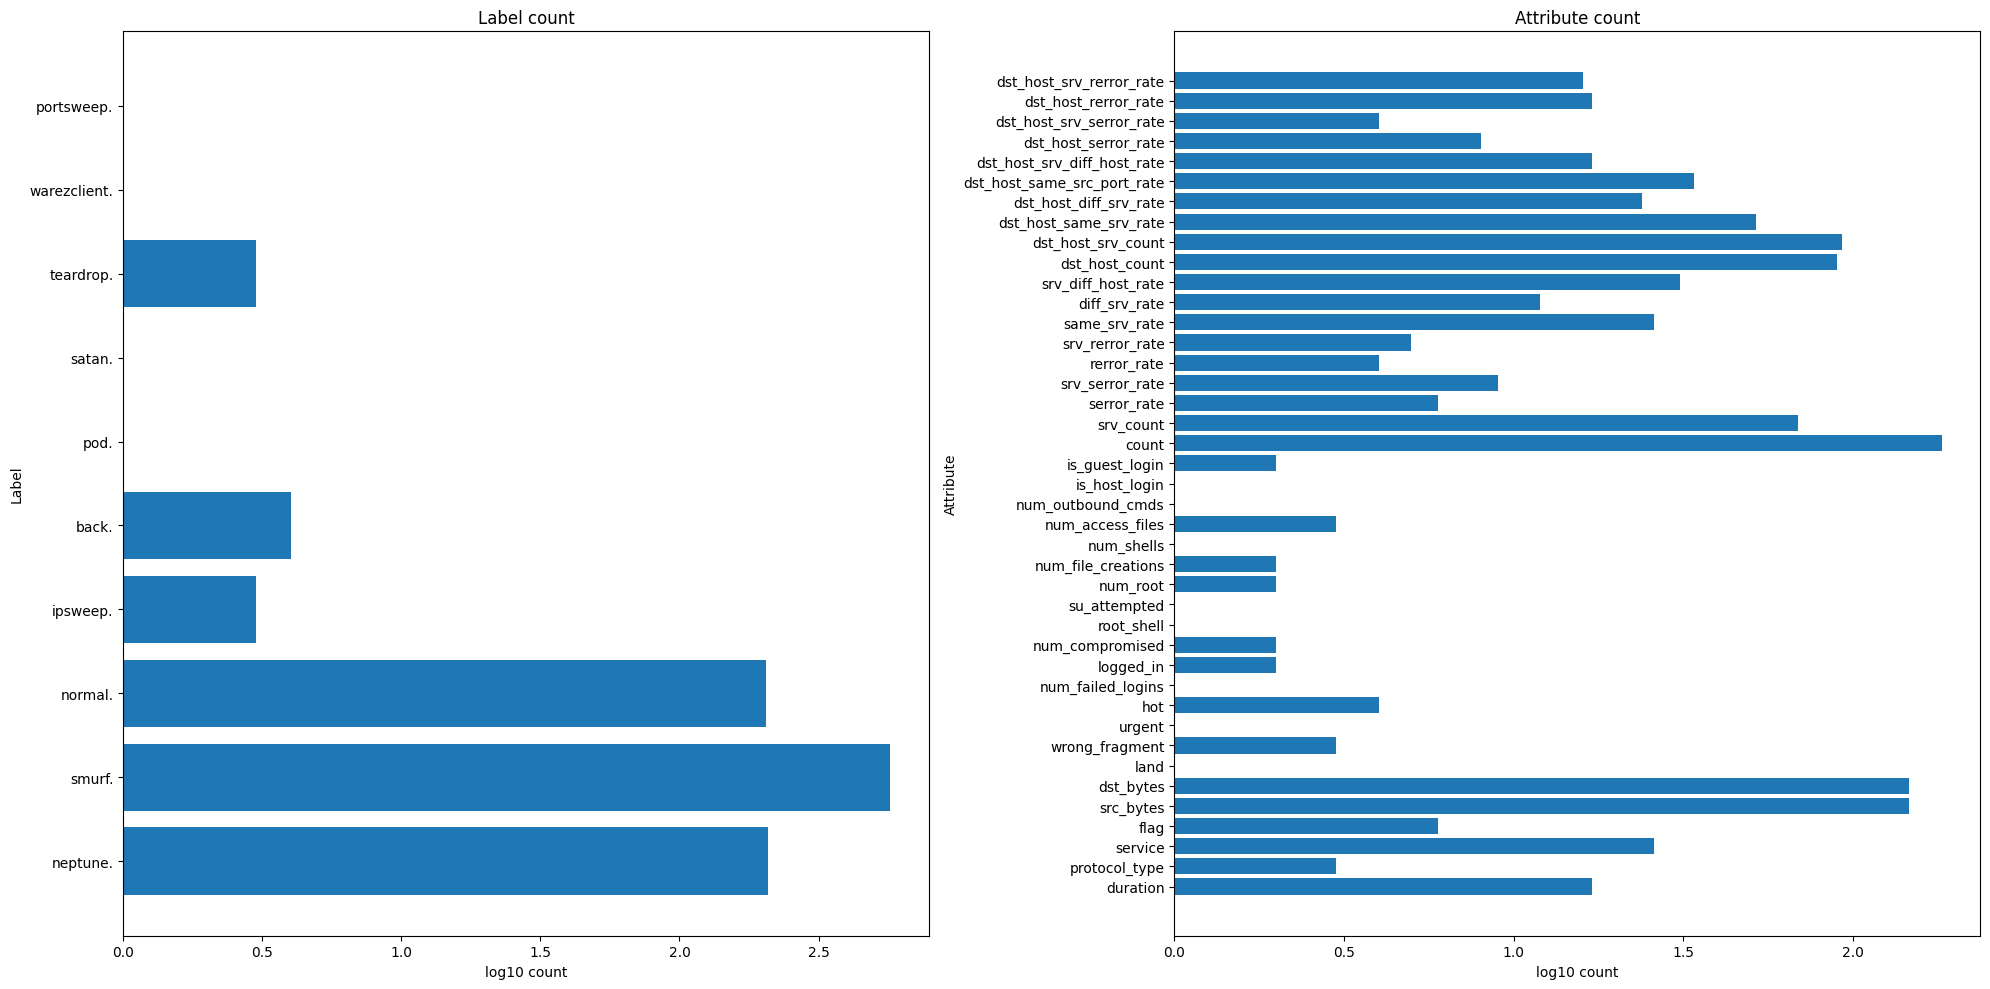

In [22]:
# add log 10 the ax and npt the count
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].barh(yUnique, np.log10(xUnique))
ax[0].set_xlabel("log10 count")
ax[0].set_ylabel("Label")
ax[0].set_title("Label count")
ax[1].barh(attributes, np.log10(uniquesParallel))
ax[1].set_xlabel("log10 count")
ax[1].set_ylabel("Attribute")
ax[1].set_title("Attribute count")
fig.tight_layout()

Deleted the categorical attriutes

In [23]:
def deleteBytes(datum):
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    print(x)
    print(mask)
    return datum

In [24]:
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [25]:
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

The number of columns (dimensionality) after filtering the bytes is 38


# DATA PROCESSING

## HELPER FUNCTIONS

In [26]:
def localPlusPlusInit(points, k): 
    #print('pointsshape: ', points.shape)
    '''
    Initialization kmeans ++
    points is a numpy array (n,dim)
    '''
    C=points[np.random.choice(points.shape[0])]#sample from array di punti ecc...
    C=C[np.newaxis, :]
    for _ in range(k):
        #points is array (n, dim), C is array(g<=k, dim)
        #probs is array (n,1)
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        #probs=[min([sum((point-centroid)**2) for centroid in C]) for point in points] #numpyfy this, or numbafy if left base python
        probs=probs/np.sum(probs)
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        #print('LE FORME',C.shape, nextCentroid.shape)
        C=np.vstack((C, nextCentroid))
    return C

In [27]:
def weightedAverage(group):
    """
    Function to compute the weighted average
    """
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages

In [28]:
def localLloyds(points, k, weights=None, n_iterations=100):
    """
    function that does the Local Lloyds algorithm
    """
    df=pd.DataFrame(points)
    if weights is None:
        weights=np.ones(shape=len(points))
    #print('weights', weights)
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))
    C=localPlusPlusInit(points, k)
    #print('localPlusPluisInit: ', C)
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1), axis=1)
        #print(clusterId)
        
    return C_array   

In [29]:
def minmaxRescale(datum, minS, maxS):
    """
    Rescale a datum in [0,1]
    """
    mask = (minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]}) 

In [30]:
def selectCluster(datum, C, updateDistances=True):
    """
    Associates a datum to its centroid and updates the distance if True
    dimC(k, len(datum))
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])

In [31]:
def updateCentroids(Rdd):
    """
    update centroids as 'centers of mass' of clusters
    """
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


In [32]:
def updateDistances(Rdd, C):
    """
    update the Rdd with square distances from centroids, given Rdd with centroids already updated
    """
    def datumUpdate(datum, C):
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd

In [33]:
def cost(Rdd):
    """
    calculate global cost of X,C from an Rdd with distances from centroids already updated
    """
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
               .reduce(lambda a,b: a+b)
    return my_cost 

In [34]:
def naiveInitFromSet(Rdd, k):
    """
    uniform sampling of k points from Rdd
    """
    kSubset=Rdd.takeSample(False, k)
    # Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!! Check if causes problems in the algorithm (i.e. need to pre-filter) or it's ok
    C_init=np.array([datum[1]['x'] for datum in kSubset])
    return C_init


def naiveInitFromSpace(k, dim):
    """
    #uniform drawing of k points from euclidean space
    #we assume the Rdd has been mapped into a [0,1]^dim space
    """
    C_init=np.random.uniform(size=(k,dim))
    return C_init

In [35]:
def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    kMeans in parallel (?)
    """
    my_kMeansCosts = []
    tIterations = []
    C=C_init

    for t in range(maxIterations):
        t1 = time()
        RddCached = Rdd.map(lambda datum: selectCluster(datum, C)).persist()
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        # Need to check that all centroids are assigned to at least one point, otherwise k changes!!! Solutions?!
        C=updateCentroids(RddCached)
        my_cost = cost(RddCached)
        
        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
        #RddCached.unpersist() bad for time efficiency, not necessary due to Python Garbage collector
        
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        
    return C

In [36]:
def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    """
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # Associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C).persist()
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1

    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist()
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100)

    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
    
    return C_init

Parallel initialization
1: C ← sample a point uniformly at random from X
2: ψ ← φX (C)
3: for O(log ψ) times do
4:
C 0 ← sample each point x ∈ X independently with
2
(x,C)
probability px = `·d
φX (C)
0
5:
C ←C∪C
6: end for
7: For x ∈ C, set wx to be the number of points in X closer
to x than any other point in C
8: Recluster the weighted points in C into k clusters

## PARALLEL PART

Compute the min and the max for each attribute and rescale

In [37]:
%%time
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
         .persist()

CPU times: user 7.69 ms, sys: 9.26 ms, total: 17 ms
Wall time: 812 ms


In [38]:
%%time
logParallelInit = {}
logParallelKmeans = {}

k=kTrue
l=k*2 # rescaling probability to have more centroids than k

# inizialize the centroids with kmeans parallel and compute C after the iterations
C_init = parallelInit(Rdd, k, l, logParallelInit)

CPU times: user 1.41 s, sys: 23.8 ms, total: 1.43 s
Wall time: 10.4 s


In [39]:
%%time
C = kMeans(Rdd, C_init, 15, logParallelKmeans)
Rdd=Rdd.map(lambda datum: selectCluster(datum, C))

CPU times: user 225 ms, sys: 53.2 ms, total: 278 ms
Wall time: 12.2 s


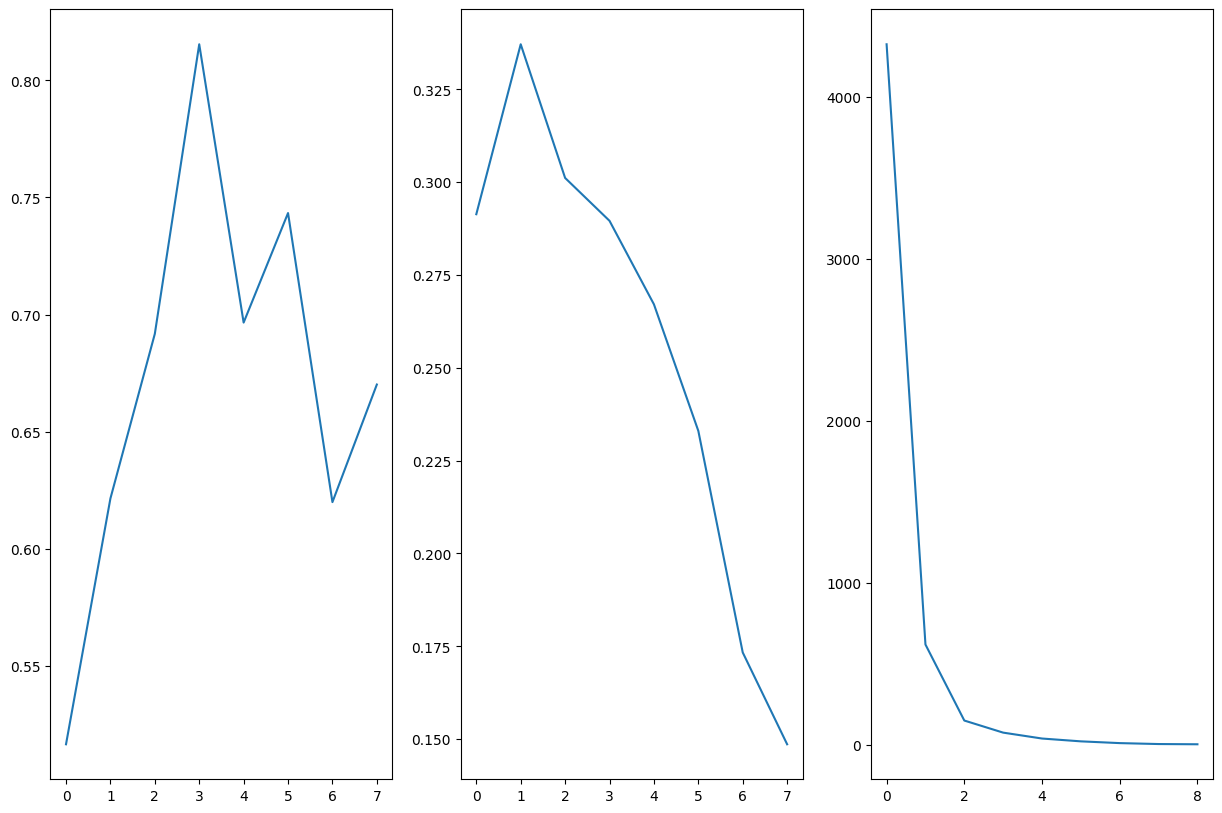

In [40]:
fig, ax=plt.subplots(1,3, figsize=(15,10))
ax[0].plot(logParallelInit["tCentroids"])
ax[1].plot(logParallelInit["tSamples"])
ax[2].plot(logParallelInit["CostInit"])

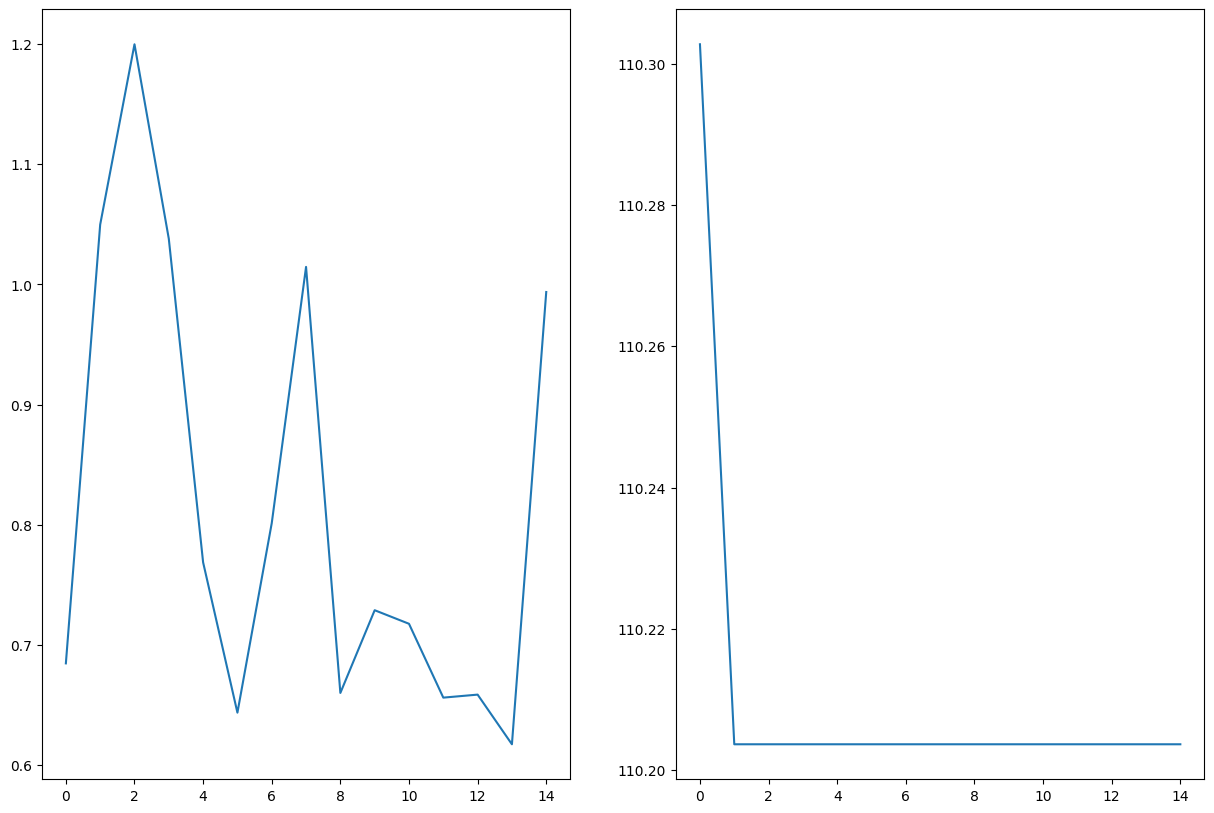

In [41]:
fig, ax=plt.subplots(1,2, figsize=(15,10))
ax[0].plot(logParallelKmeans["tIterations"])
ax[1].plot(logParallelKmeans["CostsKmeans"])